In [1]:
"""Examine SVD of convolution for 1D case"""

'Examine SVD of convolution for 1D case'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from common.operators import custom_operator_1d
from common.utils import step_func_gen
from deblurring.blurring import gaussian

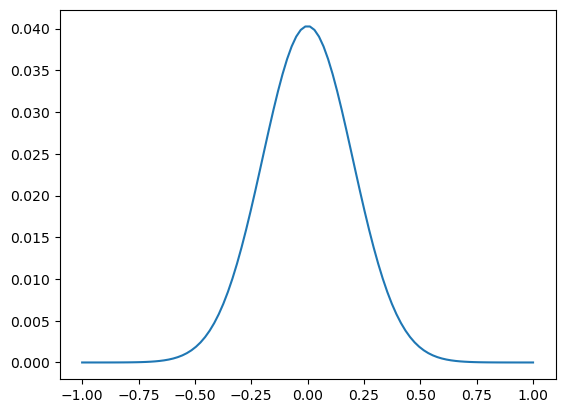

In [3]:
"""Generate and display Gaussian kernel"""

N = 100
mu = 0.0
sigma = 0.2

x = np.linspace(-1.0, 1.0, N)
y = gaussian(x, mu, sigma)
assert np.isclose(np.sum(y), 1.0)

plt.plot(x, y)
plt.show()

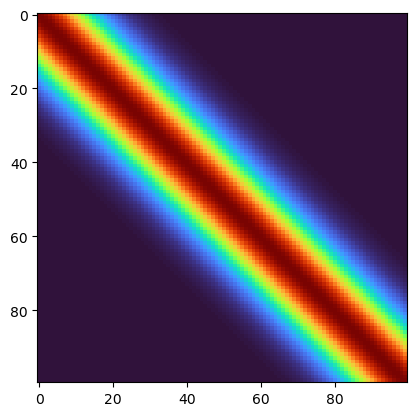

In [4]:
"""Generate and display convolutional matrix for Gaussian blurring"""

conv_matrix = custom_operator_1d(kernel=y, arr_size=N, conv_mode="same").toarray()

plt.imshow(conv_matrix, cmap="turbo")
plt.show()

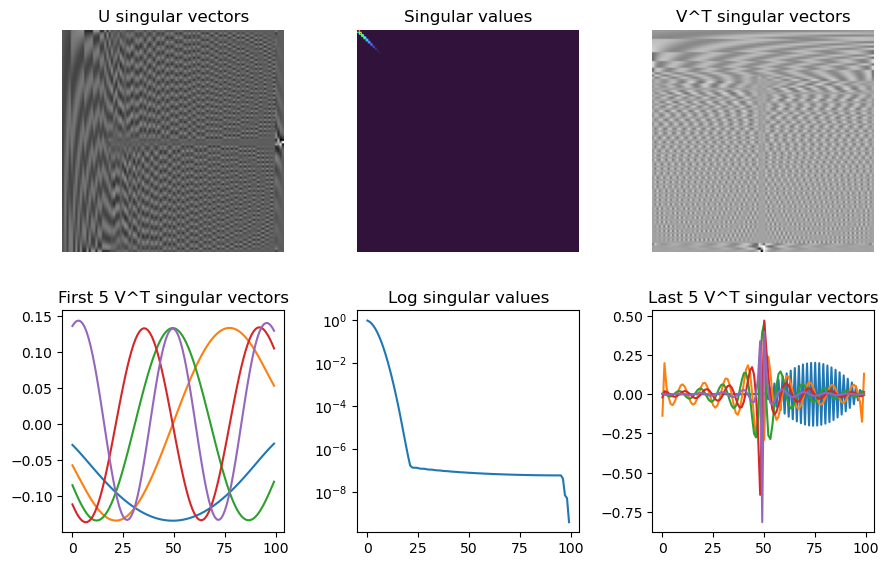

In [5]:
"""Perform singular value decomposition of convolutional matrix for n=100"""

U, W, Vt = np.linalg.svd(conv_matrix)
W_diag = np.diag(W)
assert np.isclose(np.linalg.norm(U @ W_diag @ Vt - conv_matrix), 0.0)

sing_vals = np.arange(0, W.shape[0])

fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 3, 1)
plt.imshow(U, cmap="gray")
plt.title("U singular vectors")
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(W_diag, cmap="turbo")
plt.title("Singular values")
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(Vt, cmap="gray")
plt.title("V^T singular vectors")
plt.axis("off")

plt.subplot(2, 3, 4)
for i in range(5):
    plt.plot(sing_vals, Vt[i, :])
plt.gca().set_box_aspect(1)
plt.title("First 5 V^T singular vectors")

plt.subplot(2, 3, 5)
plt.semilogy(sing_vals, W.flatten())
plt.title("Log singular values")
plt.gca().set_box_aspect(1)

plt.subplot(2, 3, 6)
for i in range(Vt.shape[0] - 5, Vt.shape[0]):
    plt.plot(sing_vals, Vt[i, :])
plt.gca().set_box_aspect(1)
plt.title("Last 5 V^T singular vectors")

plt.tight_layout()
plt.show()

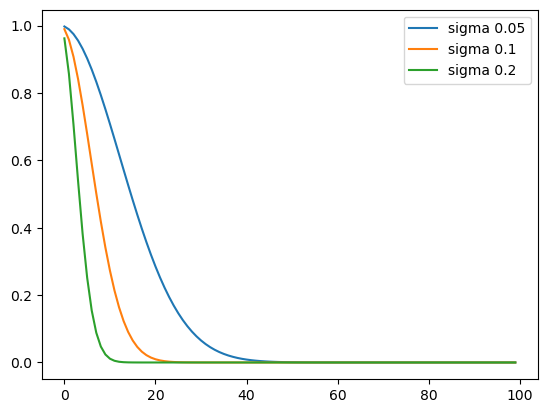

In [6]:
"""Iterate through different blurring kernel standard deviations and plot spectra"""

sigmas = [0.05, 0.1, 0.2]
sing_vals = np.zeros((len(sigmas), 100))
x = np.linspace(-1, 1, 100)

fig = plt.figure()

for i, sigma in enumerate(sigmas):
    k = gaussian(x=x, mu=0.0, sigma=sigma)
    A = custom_operator_1d(kernel=k, arr_size=100).toarray()
    U, W, Vt = np.linalg.svd(A)
    sing_vals[i, :] = W
    plt.plot(W, label=f"sigma {sigma}")

plt.legend()
plt.show()

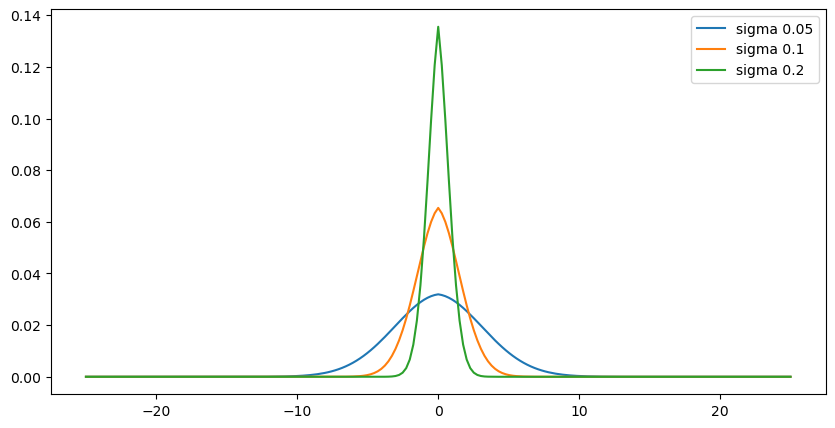

In [7]:
"""Examine whether spectra are Gaussian"""

# Assume singular vals are symmetrical Gaussian on range [-1, 1]
num_samples = 100
x_min, x_max = -1, 1
delta_k = 1 / (x_max - x_min)  # Freq step size
k_min = -num_samples / 2 * delta_k
k_max = num_samples / 2 * delta_k
k_vals = np.linspace(k_min, k_max, num_samples * 2 - 1)  # Freq values

sing_vals_reflect = np.zeros((len(sigmas), num_samples * 2 - 1))

fig = plt.figure(figsize=(10, 5))

for j in range(len(sigmas)):
    sing_vals_reflect[j, 100:] = sing_vals[j, 1:]
    sing_vals_reflect[j, 0:100] = sing_vals[j, ::-1]
    sing_vals_reflect[j, :] /= sing_vals_reflect[j, :].sum()

    plt.plot(k_vals, sing_vals_reflect[j, :], label=f"sigma {sigmas[j]}")

plt.legend()
plt.show()

In [8]:
"""Estimate standard deviation"""

for i in range(len(sigmas)):
    std_dev = np.sqrt(np.average(np.square(k_vals), weights=sing_vals_reflect[i, :]))
    print(f"Blur kernel std {sigmas[i]}: singular value std {std_dev}")

Blur kernel std 0.05: singular value std 3.253170247556694
Blur kernel std 0.1: singular value std 1.6344819075319945
Blur kernel std 0.2: singular value std 0.8269967955780666


In [9]:
"""Create convolution matrix and perform SVD."""

N = 500
_, f = step_func_gen(N)
conv_matrix = custom_operator_1d(kernel=y, arr_size=N, conv_mode="same").toarray()
U, _, Vt = np.linalg.svd(conv_matrix)

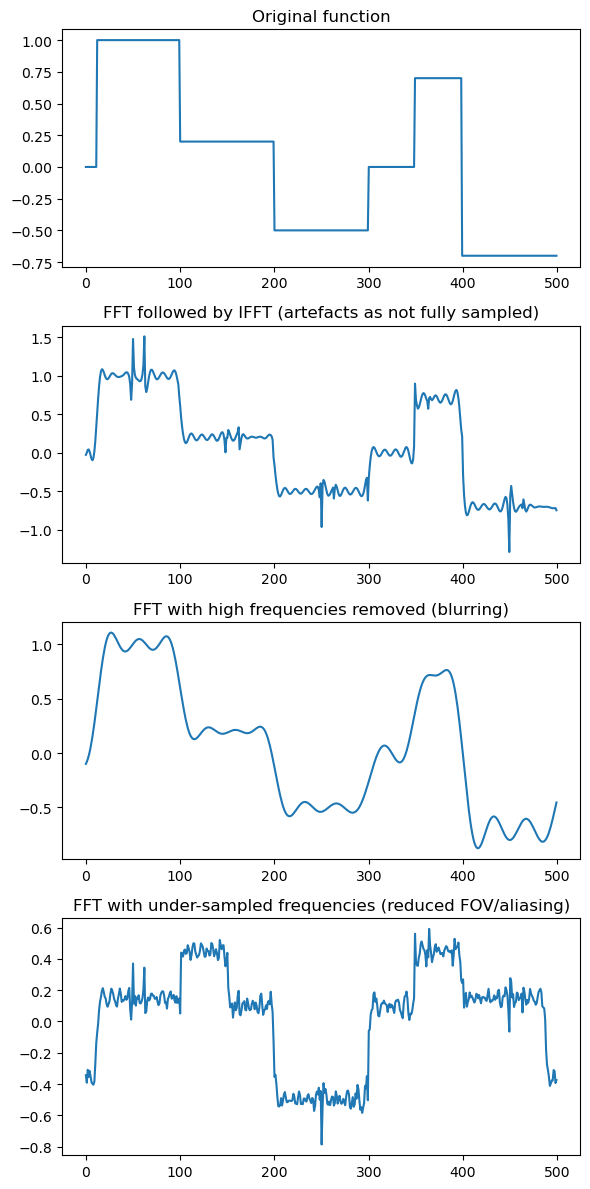

In [10]:
"""Show that V^T and U act as FFT and IFFT operators."""

plt.figure(figsize=(6, 12))
plt.subplot(4, 1, 1)
plt.plot(f)
plt.title("Original function")
plt.subplot(4, 1, 2)
plt.plot(U @ Vt @ f)
plt.title("FFT followed by IFFT (artefacts as not fully sampled)")
plt.subplot(4, 1, 3)
plt.plot(U[:, 0:30] @ Vt[0:30, :] @ f)
plt.title("FFT with high frequencies removed (blurring)")
plt.subplot(4, 1, 4)
plt.plot(U[:, ::2] @ Vt[::2, :] @ f)
plt.title("FFT with under-sampled frequencies (reduced FOV/aliasing)")

plt.tight_layout()
plt.show()